## Group Members:
- Franziska Fobbe
- Maria Guaranda
- Galo Castillo

# [TC1] Lab exercise 1: SVM training

In this lab exercise you will code 3 different algorithms to train a binary SVM classifier:

1. sub-gradient descent on the primal
2. projected gradient ascent on the dual
3. box constrained coordinate ascent on the dual

We will use a toy dataset generated via scikit learn, therefore it is easy to achieve 100% accuracy even if your algorithm is wrong! You should be extremely careful with you implementation, you need to check yourself that you precisely understand what you are coding. :)

Contrary to the course, here I ask you to have a hyperparameter to weight the regularization term.
You need to redo the math to check what this update changes in the primal and dual problem optimization algorithms.
If you don't want to mess with the math, you can first implement everything with the formula of the course, and then update to take into account the regularization term!

You need to submit both this completed notebook and a report.
See the course webpage for more information.

## Tensor operations

You **must** learn to code using tensor operation only.
In other word, you **should not** use for loops in your code when compute things.
The only for loops you need are already written!

The reason is that it makes everything simpler to understand and that Numpy (or other libraries) can vectorize the operations on CPU (or GPU in the case of libraries like Pytorch) to accelarate computation.

https://en.wikipedia.org/wiki/Array_programming

## Preliminaries

You need to install the following libraries: numpy, scikit-learn and matplotlib.
Please refer to the internet for instruction if you don't know how to do that.

In [ ]:
import numpy as np
import sklearn.datasets

import matplotlib.pyplot as plt
%matplotlib inline

Numpy is one of the most popular numerical computation library in Python.
For this lab exercise we are mainly interested in tensor computation.

It is really important that you take time to understand how Numpy works. A short tutorial is available here: https://cs231n.github.io/python-numpy-tutorial/

Take time to do a few test, understand the different operation, the different between in-place and out-of-place operations, etc.
The most important resource you **must** use is the numpy documentation.
As we usually say in computer science: Read The F*cking Manual https://numpy.org/doc/stable/reference/index.html

In [ ]:
# create a 2D tensor of shape (2, 5) full of zeros
# by default the tensor will contain elements of type float
t = np.zeros((2, 5))
print("Shape of the tensor: ", t.shape)
print("Content:")
print(t)

Shape of the tensor:  (2, 5)
Content:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
# You can reshape tensors
# When you reshape a tensor, it does not change the data order in the underlying memory.
# By default, this is the "C array order", also called the row-major format.
# If you don't know about this, check the wikipedia page:
# https://en.wikipedia.org/wiki/Row-_and_column-major_order

# for example, the following operation will reshape t as a vector with ten elements
t = t.reshape(-1) # -1 means "put every there"
print(t.shape)

# here instead of having a vector we build a tensor with a single row with ten elements
t = t.reshape(1, -1)
# of cours we could have done t = t.reshape(1, 10)
print(t.shape)

# here a tensor with a single column with ten elements
t = t.reshape(-1, 1)
# of cours we could have done t = t.reshape(10, 1)
print(t.shape)

# reshape into the original shape
t = t.reshape(2, -1)
print(t.shape)

(10,)
(1, 10)
(10, 1)
(2, 5)


In [ ]:
# this creates a vector with values from 0 to 3 (not included)
t = np.arange(4)
print(t)

# reshape
t = t.reshape((2, 2))
print(t)

# .T returns the transposed tensor
print(t.T)

[0 1 2 3]
[[0 1]
 [2 3]]
[[0 2]
 [1 3]]


In [ ]:
# set the first element of the second row to one and display the new data
# this is an in-place operation: it directly modifes the tensor memory
t[1, 0] = 1.
print("New content:")
print(t)

New content:
[[0 1]
 [1 3]]


In [ ]:
# multiply the content of the tensor by two
# this is an out-of-place operation: it does not modify the tensory memory but creates a new one
t2 = 2 * t

print("Original tensor:")
print(t)
print("New tensor:")
print(t2)

Original tensor:
[[0 1]
 [1 3]]
New tensor:
[[0 2]
 [2 6]]


In [ ]:
# do the same thing but in-place
t *= 2
print("New content:")
print(t)

New content:
[[0 2]
 [2 6]]


In [ ]:
# There are two multiplication operators:
# * is the element wise multiplication operator (also called the Hadamard product)
# @ is the matrix multiplication operator

a = np.arange(4).reshape(2, 2)
# one_like create a tensor with the same properties (i.e. type and shape) than the argument
# but filled with ones
b = 2 * np.ones_like(a) 

print("a:")
print(a)
print("b:")
print(b)
print()

# element wise multiplication
c = a * b
print("a * b:")
print(c)
print()

# matrix multiplication
c = a @ b
print("a @ b:")
print(c)

a:
[[0 1]
 [2 3]]
b:
[[2 2]
 [2 2]]

a * b:
[[0 2]
 [4 6]]

a @ b:
[[ 2  2]
 [10 10]]


In [ ]:
# you can easily retrieve one row or one column of a tensor
print("a:")
print(a)
print()

print("first row of a:")
print(a[0])
print()

print("first column of a:")
print(a[:, 0])

a:
[[0 1]
 [2 3]]

first row of a:
[0 1]

first column of a:
[0 2]


In [ ]:
# the same approach can be used to update the data in-place
print("a:")
print(a)
print()

# set the second colums elements to 10
a[:, 1] = 10.
print("after update:")
print(a)

a:
[[0 1]
 [2 3]]

after update:
[[ 0 10]
 [ 2 10]]


One of the most important feature you have to understand is **broadcasting**.
You can read the following article to understand operation broadcasting: https://numpy.org/devdocs/user/theory.broadcasting.html

It is a very important concept that is really helpful in numpy and other numerical computation library.
The documentation often explain of broadcasting is implemented for a given operation, check for example the matrix multiplication page: https://numpy.org/doc/stable/reference/generated/numpy.matmul.html

In [ ]:
a = np.arange(6).reshape(2, -1)
print("a: ")
print(a)
print()

# we will multpliy the first row by 2 and the second row by 4 by using operation broadcasting
# np.array can be used to create a tensor from python data
b = np.array([2, 4]).reshape((2, 1))
print('b: ')
print(b)
c = a * b

print("new tensor:")
print(c)

a: 
[[0 1 2]
 [3 4 5]]

b: 
[[2]
 [4]]
new tensor:
[[ 0  2  4]
 [12 16 20]]


## Plotting

We will use the following function to plot the data.
The first argument is mandatory and the two last are optional.

- x: data to plot. It must be of shape (number of datapoints, number of dimensions). Only the two first dimension will be used for horizontal and vertical dimensions, respectively. This means you can use the third dimension for the bias term!
- y: labels. It must be of shape (number of datapoints,), that is a single dimension vector. Value must be either -1 (displayed in blue) or +1 (displayed in red)
- a: parameters of a linear binary classifiers. Should be of shape (3,), that is a vector with three elements. The last element is the bias term! This argument is used to display the decision boundary (the hyperplane that separates the two classes)

In [ ]:
# plot only the two first features as the two first dim
# other features will be ignored, so we can use them for the bias term for example
def plot(x, y=None, a=None):
    data_colors = np.array(["blue", "red"])
    if y is None:
        c = None
    else:
        c = data_colors[((y + 1) // 2).astype(int)]
        
    plt.scatter(x[:, 0], x[:, 1], c=c)
    
    if a is not None:
        left = np.min(x[:, 0] - 1)
        right = np.max(x[:, 0] + 1)

        left_y = -(a[2] + a[0]*left) / a[1]
        right_y = -(a[2] + a[0]*right) / a[1]

        plt.plot([left, right], [left_y, right_y], c='black')
    
    axes = plt.gca()
    axes.set_xlim([np.min(x[:, 0]) - 1,np.max(x[:, 0]) + 1])
    axes.set_ylim([np.min(x[:, 1]) - 1,np.max(x[:, 1]) + 1])
    plt.show()

## Data generation

We use scikit-learn to generate a toy dataset.
After you completed the lab exercise, you should play with dataset generation to generate non-separable data or even other kind of dataset, check the scikit-learn documentation! https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [ ]:
SEED = 2222 # this constant will be used to determine a random number generation for dataset creation, so to get a reproducible output 
X_no_bias, y_gold = sklearn.datasets.make_classification(
    n_samples=200,
    n_features=2,
    n_classes=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=3. ,  # default=1
    random_state = SEED 
)

# replace 0/1 labels with -1/1 labels
y_gold = y_gold * 2 - 1

# add a third feature which will be used for the bias term
X = np.empty((X_no_bias.shape[0], 3))
X[:,:2] = X_no_bias
X[:,2] = 1.

# create a diagonal vector containing labels
# (see the course to understand why this is useful)
Y_gold = np.diag(y_gold)

In [ ]:
# so we have two different tensors containing the gold labels,
# use the most useful ones!
print(X.shape)
print(y_gold.shape)
print(Y_gold.shape)

(200, 3)
(200,)
(200, 200)


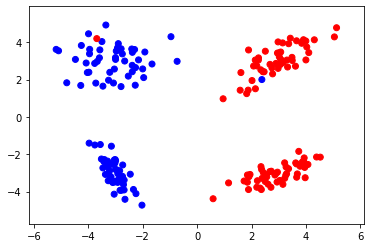

In [ ]:
# plot the data
plot(X, y_gold)

In [ ]:
np.random.seed(1) # To make our experiments reproducible

# First step!

The first two functions to code are:
- predict(a, X): returns a vector of shape X.shape[0] containing the prediction given by the linear model parameterized by vector a, i.e. values in {-1, 1} for each datapoint (i.e. this function does both the scoring and prediction step)
- accuracy(gold, predicted): return the % of equal elements in the two vectors

In [ ]:
# you can use np.sign here
def predict(a, X):
    return np.sign(X@a)

# you can use == to compare values between two tensors.
# Even if == returns a vector of boolean, you can sum them via t.sum() or np.sum(t)
# to count the number of True values
def accuracy(gold, predicted):
    return np.sum(gold==predicted)/len(gold)

In [ ]:
# create a randomly initialized model
a = np.random.normal(loc=0.0, scale=0.1, size=3)

# compute the accuracy of the random model,
# it should return a value around 50,
# but the randomly generated model can also be way better/way worse
# (if you execute this cell many times you may even obtain an accuracy of 100%!)
accuracy(y_gold, predict(a, X))

0.99

# Training algorithm 1: sub-gradient descent on the primal problem

The objective function is defined as follows:
$$ \sum_i \max\left(0, 1 - X_{i} a y_i\right) + \frac{c}{2} \| a\|^2_2$$
where c is the regularization weight.

To implement this first you must first understand the following:

1. what is the gradient of the objective (there are two different cases depending of the result of the max!)
\  \begin{align*}
    &\nabla_a\max\left(0, 1 - X_{i} a y_i\right) + \frac{c}{2} \| a\|^2_2\\
    = & \begin{cases}
        c\cdot a &\text{if } \max(0, 1 - X_{i} a y_i) = 0\\
        -X_i \cdot y_i + c \cdot a & \text{if } \max(0, 1 - X_{i} a y_i) > 0
    \end{cases}
\end{align*}

2. how to use tensor operations only for computing the objective and its gradient?

For this we implement a variable `comput = 1 - X@a*predict(a, X)` which is the "right" argument of the max, as described in the hint. If we apply the mask as stated, it will be 0 when `comput < 0` and 1 when `comput > 0`. if `comput > 0` we want to include the $-X_i \cdot y_i$ part of the equation stated above, if it is not, we want to exclude it. That is why we multiply this part of the calculation with the binary mask, to vectorize the coputation of the objective. `subgradient = -(mask*X.T)@y_gold+ regularization_weight * a`

**Hint:**
for the second point, you will need to construct a mask, i.e. a vector containing values 0 and 1.
It needs to be computed as "mask = (right >= 0).astype(float)" where "right" is the right argument of the max.
Can you understand why? Can you explain why?

Accuracy at the last epoch:  0.99

Objective function:


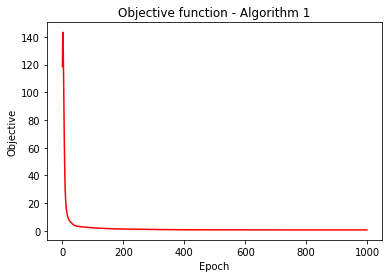

Classification accuracy:


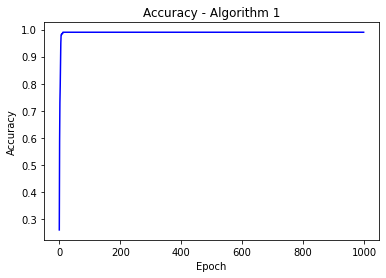

In [ ]:
def subgradient_primal_problem(X, y_gold, step_size = 1e-4, regularization_weight = 1, n_epochs = 1000):
    # initialize the model randomly
    a = np.random.normal(loc=0.0, scale=0.1, size=3)

    # append to this list the objective value (or loss) at each epoch
    objective_per_epoch = list()
    # append to this list the accuracy at each epoch
    # (evaluate on train directly, we are just playing with the optimization algorithm here)
    accuracy_per_epoch = list()

    for _ in range(n_epochs):
        # compute the objective value (and the mask!)
        comput = 1 - X@a*predict(a, X)
        obj = comput[comput>=0].sum() + regularization_weight/2 * np.sum(a*a)
        objective_per_epoch.append(obj)
        
        # compute the sub-gradient
        # We use a mask to choose including (or not) the -X.T@y_gold term on each observation. 
        mask = (comput >= 0).astype(float)
        subgradient = -(mask*X.T)@y_gold+ regularization_weight * a
        
        # update the parameters 
        a -= step_size * subgradient
        
        # compute the accuracy after the update
        accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))
    return a, accuracy_per_epoch, objective_per_epoch, regularization_weight

# hyperparameters: you can play with them!
step_size = 1e-4
regularization_weight = 1
n_epochs = 1000

a, accuracy_per_epoch, objective_per_epoch, regularization_weight = subgradient_primal_problem(X, y_gold, 1e-4, 1, 1000)

print("Accuracy at the last epoch: ", accuracy_per_epoch[-1])
print()

# display two plots:
# in red the objective value at each epoch,
# in blue accuracy at each epoch

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 1")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 1")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()


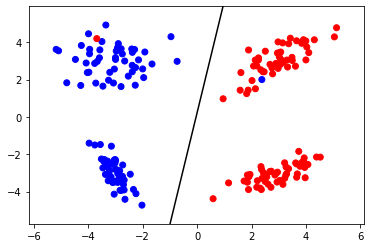

In [ ]:
# Visualization of the decision boundary
plot(X, y_gold, a)

# Training algorithm 2: projected gradient ascent on the dual problem

In this second exercise, you need to optimize the dual via projected gradent ascent:

1. what is the dual objective when we add a hyperparameter to control the weight of the regularization term?

$$  \max_\lambda \mathcal L (\lambda) = - \sum_i^n \lambda_i -\frac{1}{2c} \lambda^T YXX^T Y\lambda \\  \text s.t. -1\leq \lambda_i \leq 0 $$
This is the Lagrangian dual objective associated to the SVM problem.
2. how do we retrieve primal variables from dual variables in this case?
$$ a = -\frac{1}{c} X^T Y \lambda$$

In [ ]:
def dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight):
    return -(1/regularization_weight)*X.T@Y_gold@dual_vars

Stats at the last epoch:
 - Accuracy:  0.99
 - Number of support vectors:  46

Objective function:


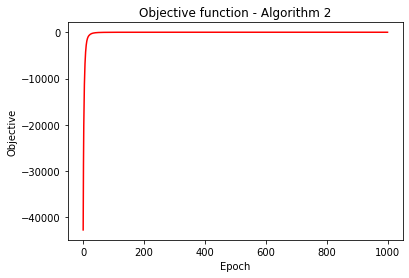

Classification accuracy:


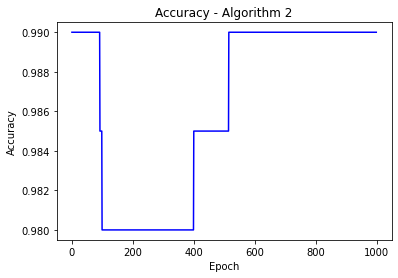

Number of support vectors:


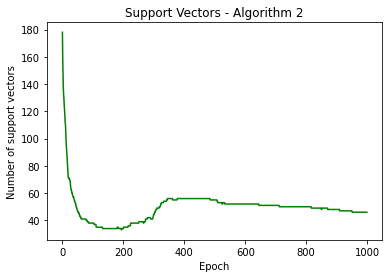

In [ ]:
def proj_gradient_ascent_dual(X, y_gold, step_size = 1e-4, regularization_weight = 1, n_epochs = 1000):
    # dual varariables initialization
    # remember that the feasible space is [-1,0]
    dual_vars = -np.random.rand(X.shape[0])

    objective_per_epoch = list()
    accuracy_per_epoch = list()
    support_vectors = list()

    Y = np.diag(y_gold)
    for _ in range(n_epochs):
        # compute the objective function
        obj = -sum(dual_vars)-(1/(2*regularization_weight))*(dual_vars.T@Y@X@X.T@Y@dual_vars)
        objective_per_epoch.append(obj)
        # compute gradient
        gradient = -1-(1/regularization_weight)*(Y@X@X.T@Y@dual_vars)

        # projected sub-gradient step
        # and project the new dual variables in the feasible space with clip function
        dual_vars += step_size*gradient
        dual_vars = np.clip(dual_vars, -1, 0)

        # evaluate
        a = dual_vars_to_primal_vars(dual_vars, X, Y, regularization_weight)
        
        # store the different accuracies per epoch
        accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))
        
        # compute the number of support vectors,
        # i.e. the number of dual vars != 0
        support_vectors.append(((dual_vars ** 2) > 1e-7).sum())

    return dual_vars, a, accuracy_per_epoch, objective_per_epoch, support_vectors

# hyperparameters: you can play with them!
step_size = 1e-4
regularization_weight = 1
n_epochs = 1000

dual_vars, a, accuracy_per_epoch, objective_per_epoch, support_vectors = proj_gradient_ascent_dual(X, y_gold, 1e-4, 1, 1000)

print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 2")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()

print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 2")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 2")
plt.ylabel("Number of support vectors")
plt.xlabel("Epoch")
plt.show()

Support vectors - projected gradient ascent algo


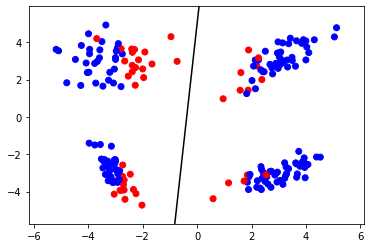

In [ ]:
# This plot will show the support vectors in red together with the separating hyperplane,
# i.e. the blue points have a dual variable = 0
print("Support vectors - projected gradient ascent algo")
plot(X, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

SVM classification - projected gradient ascent algo


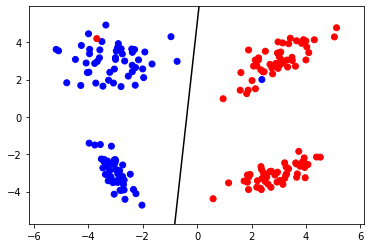

In [ ]:
# this plot use the red/blue colors to indicate the gold class,
# Visualization of the separating hyperplace 
print("SVM classification - projected gradient ascent algo")
plot(X, y_gold, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

# Training algorithm 3: box constrained coordinate ascent on the dual problem

This last algorithm does not require a stepsize.
You will need a mask to compute the numerator in the dual variable update rule! (the sum does not include the update dual var)

Stats at the last epoch:
 - Accuracy:  0.99
 - Number of support vectors:  9

Objective function:


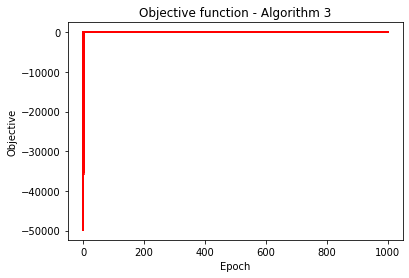

Classification accuracy:


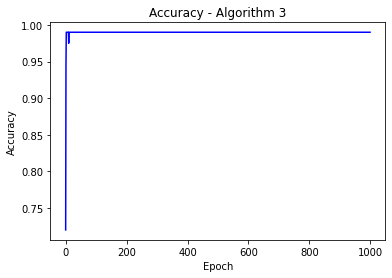

Number of support vectors:


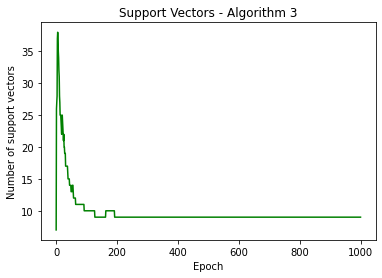

In [ ]:

def box_constrained_dual(X, y_gold, regularization_weight = 1, n_epochs = 1000):
    # initialize dual variables
    dual_vars = -np.random.rand(X.shape[0])

    objective_per_epoch = list()
    accuracy_per_epoch = list()
    support_vectors = list()

    Y = np.diag(y_gold)

    for _ in range(n_epochs):
        Q = -(1/regularization_weight)*Y@X@X.T@Y
        # compute objective
        obj = 0.5*dual_vars.T@Q@dual_vars - dual_vars
        objective_per_epoch.append(obj)
        
        # for each coordinate 
        for k in range(X.shape[0]):
            #make a copy of dual_vars just to make sure we don't accidentally modify our solutions of lambdas
            dual_vars_masked = dual_vars.copy()
            dual_vars_masked[k] = 0 #prevents adding up elements when k=i
            numerator = 1-np.dot(dual_vars_masked.T, Q[k,:]) # b is -1, bk = -(-1) = 1;
            # update the coordinate k 
            dual_vars[k] = numerator/Q[k,k] 
            # clip the solution if it does not fit in [-1,0]
            dual_vars[k] = np.clip(dual_vars[k], -1, 0) 

        # compute accuracy
        a = dual_vars_to_primal_vars(dual_vars, X, Y, regularization_weight)
        accuracy_per_epoch.append(accuracy(y_gold, predict(a, X)))
        
        # compute the number of support vectors,
        # i.e. the number of dual vars != 0
        support_vectors.append(((dual_vars ** 2) > 1e-7).sum())
    
    return objective_per_epoch, accuracy_per_epoch, support_vectors, a, dual_vars

# hyperparameters: you can play with them!
regularization_weight = 1
n_epochs = 1000

objective_per_epoch, accuracy_per_epoch, support_vectors, a, dual_vars = box_constrained_dual(X, y_gold, regularization_weight, n_epochs)


print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 3")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 3")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 3")
plt.ylabel("Number of support vectors")
plt.xlabel("Epoch")
plt.show()

Support vectors - box-constrained ascent algo


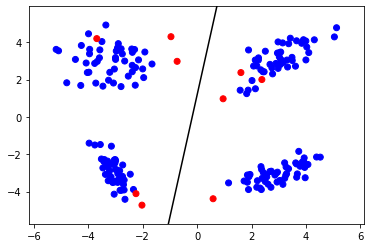

In [ ]:
# This plot will show the support vectors in red together with the separating hyperplane,
# i.e. the blue points have a dual variable = 0
print("Support vectors - box-constrained ascent algo")
plot(X, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

SVM classification - Box-constrained ascent algo


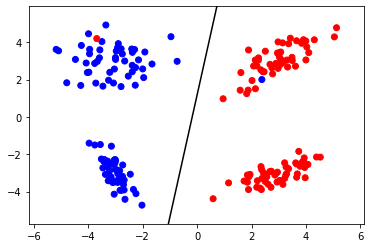

In [ ]:
# this plot use the red/blue colors to indicate the gold class,
# Visualization of the separating hyperplace 
print("SVM classification - Box-constrained ascent algo")
plot(X, y_gold, dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight))

In [ ]:
# Check the support vectors
# Support vectors are points where the constraint is tight, this is, when y_gold(ax)=1, where a are the weights, y_gold is the true label of the point, and x is the data point
# Also, the support vectors are the only ones that contribute to the objective function, this is, they are the only ones where the lambdas are not zero

# 1.get the real weights
primal_vars = dual_vars_to_primal_vars(dual_vars, X, Y_gold, regularization_weight)

# 2.get the positions where the lambdas are not zero
y = ((dual_vars ** 2) > 1e-7)

# 3. compute (XA)Y to get the multiplication between the predicted and real labels
sv = X@primal_vars@Y_gold

print((dual_vars ** 2) > 1e-7)
print("Check if the tight constraint is satisfied by the support vectors:")
print(sv[y]) #get the values of the multiplications of only the support vectors
print(dual_vars)

[False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False  True
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

To test the algorithms further we create two types of datasets:
1. A dataset that not so neatly linearly seperable as before
2. A circle dataset, that is not linearly seperable (without a matching kernel) at all


# Rerunning the algorithms with a harder, not perfectly linearly separable dataset

We are creating a larger (n = 1000) and harder to separate dataset to test the algorithms behaviour and to assess how computatinal expensive they are. 

Not completely linearly seperable dataset


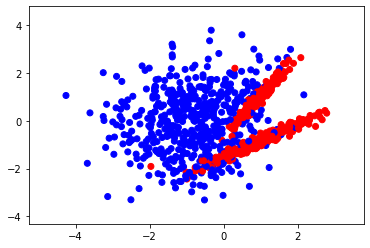

In [ ]:
#Creation of a bigger non linearly seperable dataset
SEED = 2222 # this constant will be used to determine a random number generation for dataset creation, so to get a reproducible output 
X_no_bias_ns, y_gold_ns = sklearn.datasets.make_classification(
 n_samples=1000, n_features=2, n_redundant=0, n_informative=2, random_state=SEED, n_clusters_per_class=2, class_sep=0.9
)

# replace 0/1 labels with -1/1 labels
y_gold_ns = y_gold_ns * 2 - 1

# add a third feature which will be used for the bias term
X_ns = np.empty((X_no_bias_ns.shape[0], 3))
X_ns[:,:2] = X_no_bias_ns
X_ns[:,2] = 1.

# create a diagonal vector containing labels
# (see the course to understand why this is useful)
Y_gold_ns = np.diag(y_gold_ns)

print("Not completely linearly seperable dataset")
plot(X_ns, y_gold_ns)

Accuracy at the last epoch:  0.905

Objective function for not completely linearly seperable dataset:


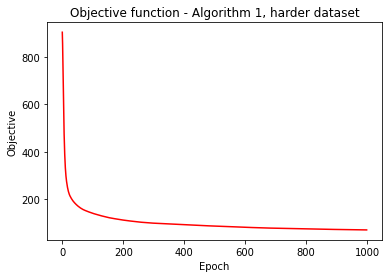

Classification accuracy for not completely linearly seperable dataset:


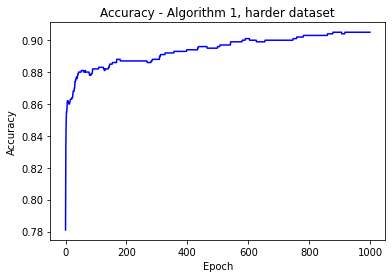

In [ ]:
a, accuracy_per_epoch, objective_per_epoch, regularization_weight = subgradient_primal_problem(X_ns, y_gold_ns)

print("Accuracy at the last epoch: ", accuracy_per_epoch[-1])
print()

# display two plots:
# in red the objective value at each epoch,
# in blue accuracy at each epoch

print("Objective function for not completely linearly seperable dataset:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 1, harder dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy for not completely linearly seperable dataset:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 1, harder dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Stats at the last epoch:
 - Accuracy:  0.895
 - Number of support vectors:  526

Objective function:


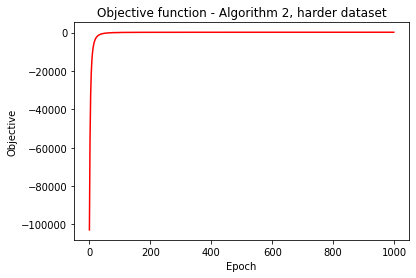

Classification accuracy:


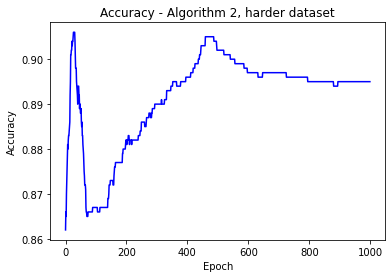

Number of support vectors:


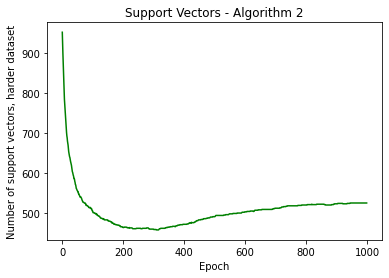

In [ ]:
dual_vars, a, accuracy_per_epoch, objective_per_epoch, support_vectors = proj_gradient_ascent_dual(X_ns, y_gold_ns)
    
print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 2, harder dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()

print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 2, harder dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 2")
plt.ylabel("Number of support vectors, harder dataset")
plt.xlabel("Epoch")
plt.show()

Support vectors - projected gradient ascent algo, harder dataset


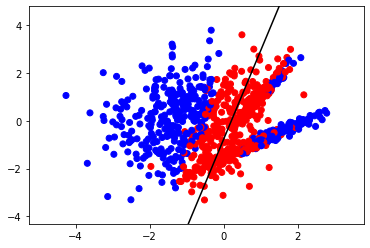

In [ ]:
print("Support vectors - projected gradient ascent algo, harder dataset")
plot(X_ns, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X_ns, Y_gold_ns, regularization_weight))

Stats at the last epoch:
 - Accuracy:  0.895
 - Number of support vectors:  300

Objective function:


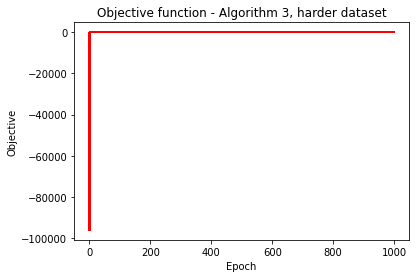

Classification accuracy:


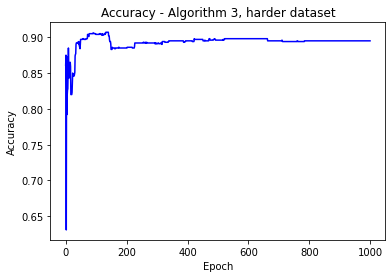

Number of support vectors:


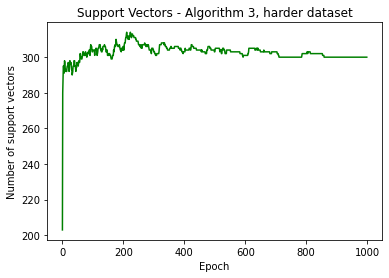

In [ ]:
objective_per_epoch, accuracy_per_epoch, support_vectors, a, dual_vars = box_constrained_dual(X_ns, y_gold_ns)


print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 3, harder dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 3, harder dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 3, harder dataset")
plt.ylabel("Number of support vectors")
plt.xlabel("Epoch")
plt.show()

Support vectors - box-constrained ascent algo, harder dataset


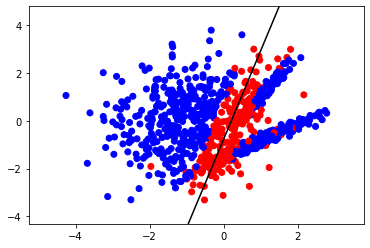

In [ ]:
print("Support vectors - box-constrained ascent algo, harder dataset")
plot(X_ns, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X_ns, Y_gold_ns, regularization_weight))

# Rerunning the algorithms with a not linearly separable dataset (circles)

We are creating a small (n=200) not linearly separable data set to assess how the algorithms perform under these conditions. 

Circle dataset


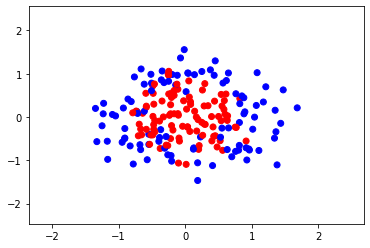

In [ ]:
from sklearn.datasets import make_circles

X_circles_no_bias, y_gold_circles = make_circles(n_samples=200, noise=0.3, factor=0.5, random_state=1)

# replace 0/1 labels with -1/1 labels
y_gold_circles = y_gold_circles * 2 - 1

# add a third feature which will be used for the bias term
X_circles = np.empty((X_circles_no_bias.shape[0], 3))
X_circles[:,:2] = X_circles_no_bias
X_circles[:,2] = 1.

# create a diagonal vector containing labels
# (see the course to understand why this is useful)
Y_gold_circles = np.diag(y_gold_circles)
print('Circle dataset')
plot(X_circles, y_gold_circles)

Accuracy at the last epoch:  0.495

Objective function:


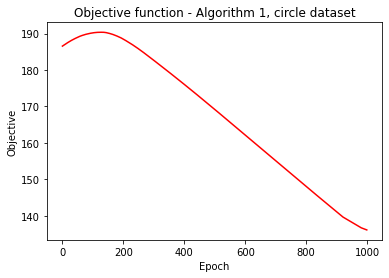

Classification accuracy:


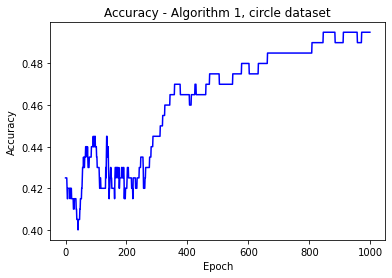

In [ ]:
a, accuracy_per_epoch, objective_per_epoch, regularization_weight = subgradient_primal_problem(X_circles, y_gold_circles)

print("Accuracy at the last epoch: ", accuracy_per_epoch[-1])
print()

# display two plots:
# in red the objective value at each epoch,
# in blue accuracy at each epoch

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 1, circle dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 1, circle dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Stats at the last epoch:
 - Accuracy:  0.53
 - Number of support vectors:  200

Objective function:


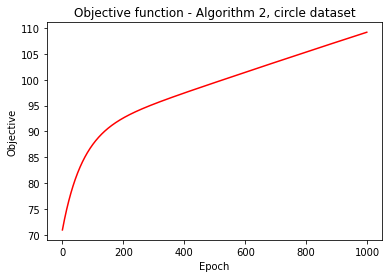

Classification accuracy:


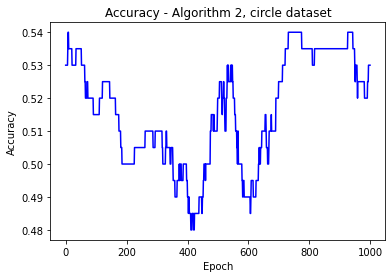

Number of support vectors:


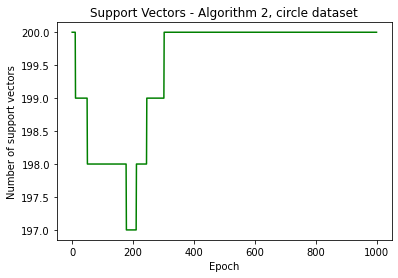

In [ ]:
dual_vars, a, accuracy_per_epoch, objective_per_epoch, support_vectors = proj_gradient_ascent_dual(X_circles, y_gold_circles)
    
print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 2, circle dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()

print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 2, circle dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 2, circle dataset")
plt.ylabel("Number of support vectors")
plt.xlabel("Epoch")
plt.show()

Support vectors - projected gradient ascent algo, circle dataset


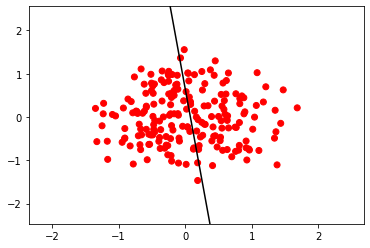

In [ ]:
print("Support vectors - projected gradient ascent algo, circle dataset")
plot(X_circles, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X_circles, Y_gold_circles, regularization_weight))

Stats at the last epoch:
 - Accuracy:  0.585
 - Number of support vectors:  197

Objective function:


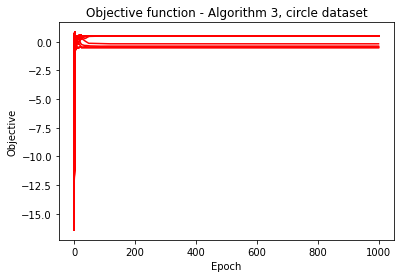

Classification accuracy:


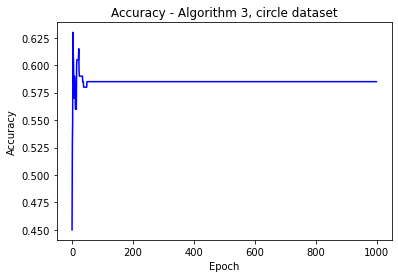

Number of support vectors:


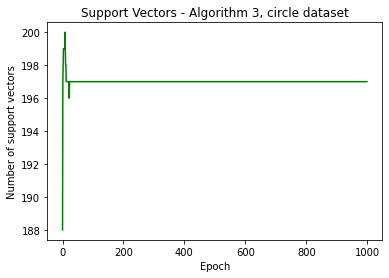

In [ ]:
objective_per_epoch, accuracy_per_epoch, support_vectors, a, dual_vars = box_constrained_dual(X_circles, y_gold_circles)


print("Stats at the last epoch:")
print(" - Accuracy: ", accuracy_per_epoch[-1])
print(" - Number of support vectors: ", support_vectors[-1])
print()

print("Objective function:")
plt.plot(objective_per_epoch, color="red")
plt.title("Objective function - Algorithm 3, circle dataset")
plt.ylabel("Objective")
plt.xlabel("Epoch")
plt.show()


print("Classification accuracy:")
plt.plot(accuracy_per_epoch, color="blue")
plt.title("Accuracy - Algorithm 3, circle dataset")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

print("Number of support vectors:")
plt.plot(support_vectors, color="green")
plt.title("Support Vectors - Algorithm 3, circle dataset")
plt.ylabel("Number of support vectors")
plt.xlabel("Epoch")
plt.show()

Support vectors - box-constrained ascent algo, circle dataset


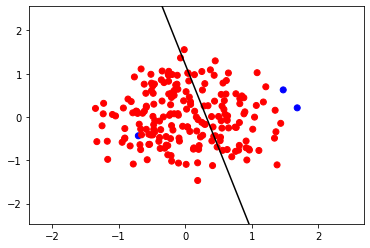

In [ ]:
print("Support vectors - box-constrained ascent algo, circle dataset")
plot(X_circles, ((dual_vars ** 2) > 1e-7)*2 - 1, dual_vars_to_primal_vars(dual_vars, X_circles, Y_gold_circles, regularization_weight))